# B2. TEST THE CNN MODEL
### Code to Test on Unseen Test Data Kept aside from the image dataset

### Importing libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image

from sklearn.model_selection import  train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

import keras
from tensorflow.keras.models import Sequential
from keras import models, layers, optimizers
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model
from keras.models import Model

In [2]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))


Num GPUs Available:  0


### Utility Functions - For preprocessing

In [4]:
# show class meta. takes class label as a number (0 to 43) and plts the meta image for the specific class
# using
def show_class_meta(class_num):
    plt.figure(figsize=(2,2))
    path = "../data/final_sign_images/Meta/" #Not able to push data to git, give local file path
    # no alternate path in git dir just dont run
    link_to_image = str(path + str(class_num) + '.png')
    class_img = imread(link_to_image)
    plt.imshow(class_img)
    plt.xlabel(class_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(class_img.shape[0], fontsize = 10)#height of image
    plt.title("Class: " + str(class_num))
    

In [5]:
# Data sets summary
# not really needed
def info_dataset(X_train, X_valid, y_train):
    # Number of training examples
    n_train = X_train.shape[0]

    # Number of validation examples
    n_validation = X_valid.shape[0]

    # Shape of an traffic sign image
    image_shape = X_train[0].shape

    # Unique classes/labels in the dataset.
    n_classes = max(y_train)+1

    print("Number of training examples =", n_train)
    print("Number of validation examples =", n_validation)
    print("Image data shape =", image_shape)
    print("Number of classes =", n_classes)

In [6]:
# Convert images to grayscale
# might delete
def RGB2GREY(data_RGB):
    
    n_data=data_RGB.shape[0]
    data_gr=np.zeros((n_data,32,32,1))
    for i in range(n_data):
        tmp = cv2.cvtColor(data_RGB[i], cv2.COLOR_RGB2GRAY)
        data_gr[i]= np.reshape(tmp,(32,32,1))
    
    return data_gr

In [7]:
#Normalisation of data if need 
def norm_data(data_gr):
    
    return (data_gr-128)/128

### Utility Functions - For plotting the Confusion Matrix

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 1. Load the Best Saved Model

In [9]:
my_model=models.load_model('./model_store/final_model.h5')

In [10]:
my_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

### 2. Load Test Data from Dataset

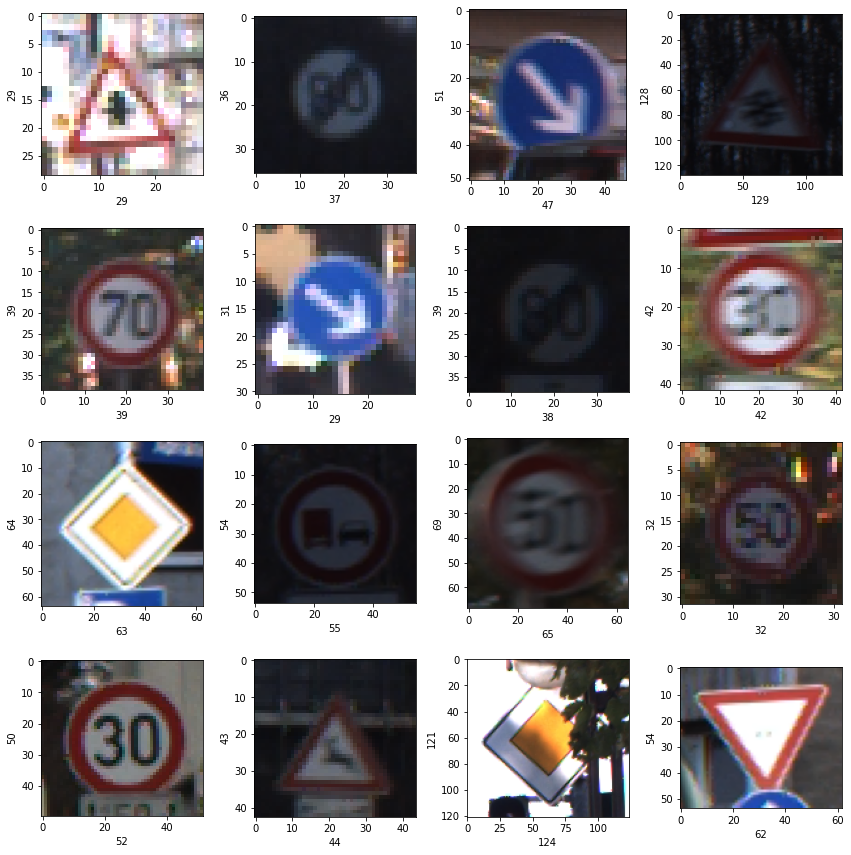

In [11]:
# just a quick explore to see some of the test images
plt.figure(figsize=(12,12))
path = "../data/final_sign_images/Test/" #Not able to push data to git, give local file path

for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path + random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [12]:
# load Test.csv for true label
test_df = pd.read_csv("../data/final_sign_images/Test.csv")
test_df.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [13]:
# create a dataframe that will store the predicted classes
pred_df = pd.DataFrame(columns=['Image_Path','ClassId','Pred_Class'])
pred_df

,Image_Path,ClassId,Pred_Class


In [14]:
# Takes a very long time do not re-run
# code to predict all 12000+ images in Test Folder
start_path ="../data/final_sign_images/"

for row in test_df.values:
    img_path = start_path + row[7]
    img = Image.open(img_path)
    img = img.resize((50,50))
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    
    # predicts the class_label
    pred = np.argmax(my_model.predict(img), axis=-1)
    
    # appends a new row to the pred_df storind the true and predicted class
    pred_df = pred_df.append({'Image_Path':row[7],'ClassId': row[6], 'Pred_Class':pred[0]}, ignore_index=True)


In [15]:
pred_df.head()

,Image_Path,ClassId,Pred_Class
0,Test/00000.png,16,16
1,Test/00001.png,1,1
2,Test/00002.png,38,38
3,Test/00003.png,33,33
4,Test/00004.png,11,11


In [16]:
pred_df.shape

(12630, 3)

In [17]:
# store the  predictions in csv
#pred_df.to_csv("./model_store/image_predictions.csv")

In [18]:
# read back the predictions made
pred_df = pd.read_csv("./model_store/image_predictions.csv")

In [19]:
# Look at the pred df that was read back from the file
pred_df.head()

,Unnamed: 0,Image_Path,ClassId,Pred_Class
0,0,Test/00000.png,16,16
1,1,Test/00001.png,1,1
2,2,Test/00002.png,38,38
3,3,Test/00003.png,33,33
4,4,Test/00004.png,11,11


In [20]:
pred_df.shape

(12630, 4)

### 3. How Good are the Predictions on Unseen Data

In [21]:
# Confusion Matrix

In [22]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

In [23]:
# setup the class_labels
class_label = list(range(0,43))

In [24]:
y_true = list(pred_df['ClassId'])
y_pred = list(pred_df['Pred_Class'])

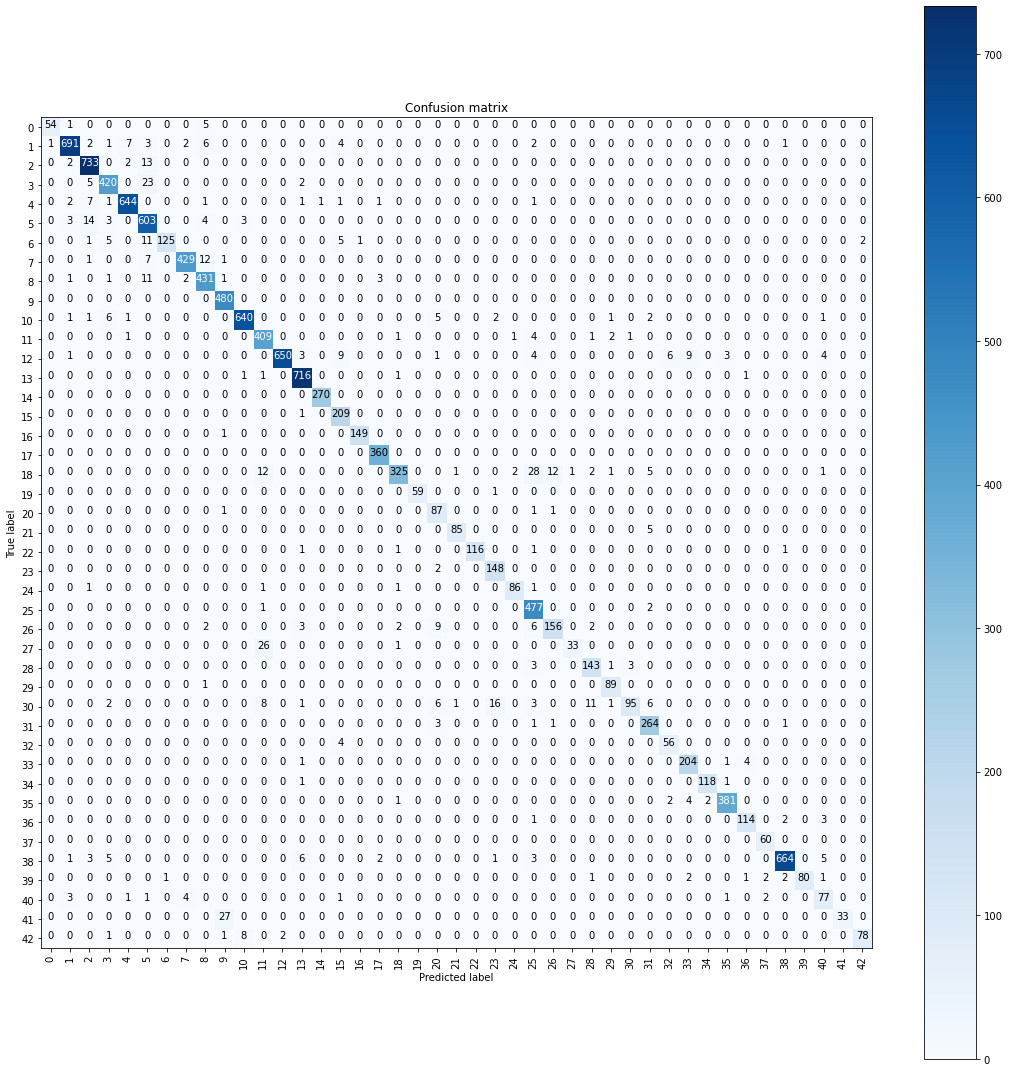

In [25]:
confusion_mtx = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(confusion_mtx, classes = class_label)

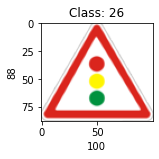

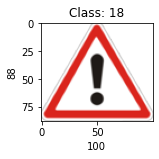

In [43]:
# 27 - 11, 18-25, 18-26, , 41-9
# Model has issues between these two classes
show_class_meta(26)# tends to choose this one
show_class_meta(18)

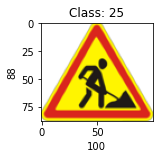

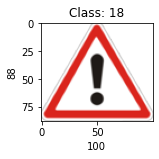

In [26]:
# Model has issues between these two classes
show_class_meta(25)
show_class_meta(18)

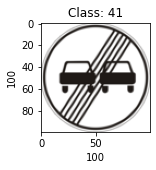

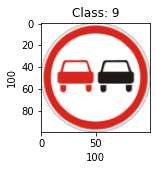

In [29]:
# Model has issues between these two classes
show_class_meta(41)
show_class_meta(9)

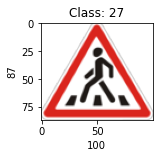

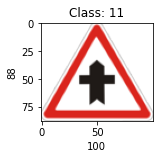

In [27]:
# Model has issues between these two classes
show_class_meta(27)
show_class_meta(11)

In [30]:
# Classification Report

In [31]:
from sklearn.metrics import classification_report

In [32]:
class_string = []
for i in range (0,43):
    label = 'Class: ' + str(i)
    class_string.append(label)

In [33]:
print(classification_report(y_true, y_pred, target_names=class_string))

              precision    recall  f1-score   support

    Class: 0       0.98      0.90      0.94        60
    Class: 1       0.98      0.96      0.97       720
    Class: 2       0.95      0.98      0.97       750
    Class: 3       0.94      0.93      0.94       450
    Class: 4       0.98      0.98      0.98       660
    Class: 5       0.90      0.96      0.93       630
    Class: 6       0.99      0.83      0.91       150
    Class: 7       0.98      0.95      0.97       450
    Class: 8       0.93      0.96      0.95       450
    Class: 9       0.94      1.00      0.97       480
   Class: 10       0.98      0.97      0.98       660
   Class: 11       0.89      0.97      0.93       420
   Class: 12       1.00      0.94      0.97       690
   Class: 13       0.97      0.99      0.98       720
   Class: 14       1.00      1.00      1.00       270
   Class: 15       0.90      1.00      0.94       210
   Class: 16       0.99      0.99      0.99       150
   Class: 17       0.98    

# NEXT - B3 CNN-TEST-REAL-IMAGES